In [1]:
import unicodedata
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler
from data_processing import prepareData, readLangs, normalizeString, filter_pair, translate_evaluate
from tqdm import tqdm
import logging

logging.basicConfig(level=logging.INFO)

logger = logging.getLogger('______')

TRAIN_DATASET_PATH = "./dataset/eng-fra-train.txt"
TEST_DATASET_PATH = "./dataset/eng-fra-test.txt"
MAXLEN, SOS_TOKEN, EOS_TOKEN = 10, 0, 1

In [2]:
def indexesFromSentence(lang, sentence):
    return [lang.word2idx[word] for word in sentence.split(' ')]
def get_dataloader(batch_size, path=TRAIN_DATASET_PATH):
    fre, eng, pairs = prepareData(path, MAXLEN)
    n = len(pairs)  
    input_ids = np.zeros((n, MAXLEN), dtype=np.int32)
    target_ids = np.zeros((n, MAXLEN), dtype=np.int32)
    
    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = indexesFromSentence(fre, inp)
        tgt_ids = indexesFromSentence(eng, tgt)
        inp_ids.append(EOS_TOKEN)
        tgt_ids.append(EOS_TOKEN)
        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    train_data = TensorDataset(torch.LongTensor(input_ids),
                               torch.LongTensor(target_ids))
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    return fre, eng, train_dataloader, train_data

In [3]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1) -> None:
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(p=dropout_p)

    def forward(self, inputx):
        # logger.debug(f'input shape : {inputx.shape}')
        embedded = self.dropout(self.embedding(inputx))
        # logger.debug(f'embedding shape: {embedded.shape}')
        output, hidden = self.gru(embedded)
        # logger.debug(f'gru output: {output.shape},  hidden: {hidden.shape}' )
        return output, hidden

In [4]:
class LuongAttention(nn.Module):
    def __init__(self, method, hidden_size, max_length=10):
        super(LuongAttention, self).__init__()
        self.method = method
        print('SELF METHOd', self.method)
        self.hidden_size = hidden_size

        if self.method == 'general':
            self.attn = nn.Linear(self.hidden_size, self.hidden_size)
        
        elif self.method == 'concat':
            self.attn = nn.Linear(self.hidden_size * 2, self.hidden_size)
            self.v = nn.Parameter(torch.FloatTensor(1, hidden_size))
    
    def score(self, query, keys):
        if self.method == 'dot':
            energy = torch.matmul(query, keys.permute(0, 2, 1))
            # print(f'energy: {energy.shape}')
            return energy
        elif self.method == 'general':
            energy = self.attn(keys)
            # print(f'energy :{energy.shape}')
            energy = torch.matmul(query, energy.permute(0, 2, 1))
            return energy
        elif self.method == 'concat':
            query_to_key_broadcast = query.expand(-1, keys.size(1), -1)
            energy = self.attn(torch.cat((query_to_key_broadcast, keys), 2))
            # print(f'energy: {energy.shape}, v: {self.v.shape}')
            energy = torch.matmul(energy, self.v.T)
            return energy.permute(0, 2, 1)
    
    def forward(self, hidden, encoder_outputs):
        score = self.score(hidden, encoder_outputs)
        # print(f'score: {score.shape}')
        attention_weights = F.softmax(score, dim=-1)
        context = torch.bmm(attention_weights, encoder_outputs)
        return context, attention_weights

In [5]:
class LuongAttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, method, dropout_p=0.1) -> None:
        super(LuongAttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = LuongAttention(method, hidden_size=hidden_size)
        self.gru = nn.GRU(hidden_size*2, hidden_size, batch_first=True)
        # self.pre_out = nn.Linear(hidden_size*2, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward_step(self, input_x, hidden, encoder_outputs):
        embedded = self.dropout(self.embedding(input_x))
        query = hidden.permute(1, 0, 2)        

        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2)
        
        gru_output, gru_hidden = self.gru(input_gru, hidden)
        output = self.out(gru_output)
        return output, gru_hidden, attn_weights


    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long).fill_(SOS_TOKEN)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        for i in range(MAXLEN):
            
            decoder_output, decoder_hidden, attn_weights = self.forward_step(decoder_input, decoder_hidden, encoder_outputs)
            
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)
            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input
        
        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)
        return decoder_outputs, decoder_hidden, attentions


In [8]:
input_lang, output_lang, train_dataloader, train_dset = get_dataloader(32)
hidden_size = 128
learning_rate = 0.001
output_size = output_lang.n_words
criterion = nn.NLLLoss() 
test_ds = []
with open(TEST_DATASET_PATH) as f:
    for line in f:
        engtext, fretext = line.split('\t')
        test_ds.append([normalizeString(fretext), normalizeString(engtext)])
    test_ds = [pair for pair in test_ds if filter_pair(pair, MAXLEN)] 


### Initialisation and training for each scoring function
```python
at_encoder = EncoderRNN(input_lang.n_words, hidden_size)
at_decoder = LuongAttnDecoderRNN(hidden_size=hidden_size, output_size=output_size, method="general")
at_encoder_optimizer = optim.Adam(at_encoder.parameters(), lr=learning_rate)
at_decoder_optimizer = optim.Adam(at_decoder.parameters(), lr=learning_rate)


EPOCHS = 3

plot_stats = {
    'bleu_test': [],
    'avg_train_loss': [],
    'avg_test_loss': []
}

for epoch in tqdm(range(EPOCHS)):
    
    dpoints = 0
    epoch_loss = 0
    at_encoder.train(), at_decoder.train()

    for batch in train_dataloader:
        input_tensor, target_tensor = batch
        at_encoder_optimizer.zero_grad()
        at_decoder_optimizer.zero_grad()
        enc_output, enc_hidden = at_encoder(input_tensor)
        decoder_outputs, decoder_hidden, _ = at_decoder(enc_output, enc_hidden, target_tensor)
        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()
        at_encoder_optimizer.step()
        at_decoder_optimizer.step()
        epoch_loss +=loss.item()
        dpoints += input_tensor.shape[0]
        
    bleu_dict, avg_test_loss = translate_evaluate(input_lang, output_lang, test_ds, at_encoder, at_decoder)
    print(f'Average Training Loss: {epoch_loss/dpoints}, Average Test Loss: {avg_test_loss}, TEST BLEU: {bleu_dict["bleu"]}')
```
   

  0%|          | 0/3 [00:00<?, ?it/s]

 33%|███▎      | 1/3 [00:10<00:20, 10.36s/it]

Average Training Loss: 0.07938748718084765, Average Test Loss: 0.18434398914983885, TEST BLEU: 0.05782714484246687


 67%|██████▋   | 2/3 [00:20<00:10, 10.29s/it]

Average Training Loss: 0.05401089288121147, Average Test Loss: 0.18453903421887843, TEST BLEU: 0.10364653575068261


100%|██████████| 3/3 [00:30<00:00, 10.27s/it]

Average Training Loss: 0.04637870818251918, Average Test Loss: 0.17566075833857367, TEST BLEU: 0.14967712563209534


In [9]:
def train_valid_loop(attention_method):
    
    at_encoder = EncoderRNN(input_lang.n_words, hidden_size)
    at_decoder = LuongAttnDecoderRNN(hidden_size=hidden_size, output_size=output_size, method=attention_method)
    at_encoder_optimizer = optim.Adam(at_encoder.parameters(), lr=learning_rate)
    at_decoder_optimizer = optim.Adam(at_decoder.parameters(), lr=learning_rate)
    EPOCHS = 50

    plot_stats = {
        'bleu_test': [],
        'avg_train_loss': [],
        'avg_test_loss': []
    }

    for epoch in tqdm(range(EPOCHS)):
        
        dpoints = 0
        epoch_loss = 0
        at_encoder.train(), at_decoder.train()

        for batch in train_dataloader:
            input_tensor, target_tensor = batch
            at_encoder_optimizer.zero_grad()
            at_decoder_optimizer.zero_grad()
            enc_output, enc_hidden = at_encoder(input_tensor)
            decoder_outputs, decoder_hidden, attention = at_decoder(enc_output, enc_hidden, target_tensor)
            loss = criterion(
                decoder_outputs.view(-1, decoder_outputs.size(-1)),
                target_tensor.view(-1)
            )
            loss.backward()
            at_encoder_optimizer.step()
            at_decoder_optimizer.step()
            epoch_loss +=loss.item()
            dpoints += input_tensor.shape[0]
        bleu_dict, test_loss = translate_evaluate(input_lang, output_lang, test_ds, at_encoder, at_decoder)
        plot_stats['bleu_test'].append(bleu_dict['bleu'])
        plot_stats['avg_train_loss'].append(epoch_loss/dpoints)
        plot_stats['avg_test_loss'].append(test_loss)
    return plot_stats




In [10]:
methods = ['general', 'dot', 'concat']

performance_dict = {method: train_valid_loop(method) for method in methods}

SELF METHOd general


100%|██████████| 50/50 [08:53<00:00, 10.67s/it]


SELF METHOd dot


100%|██████████| 50/50 [08:01<00:00,  9.63s/it]


SELF METHOd concat


100%|██████████| 50/50 [09:06<00:00, 10.93s/it]


In [14]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go


In [23]:
atten_list = list(performance_dict.keys())

colours = {"avg_train_loss":"red", 
 "avg_test_loss": "orange",
 "bleu_test": "black"}
epochs = list(range(1, 51))

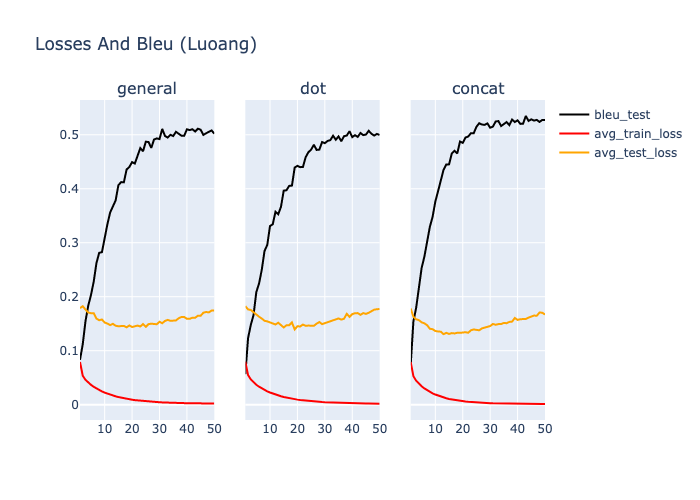

In [42]:
fig = make_subplots(rows=1, cols=3, shared_yaxes=True, column_titles=atten_list)
for plot_i, plot_name in enumerate(atten_list):
    s_legend = True if plot_i==0  else False
    for i, ks in enumerate(performance_dict[plot_name]):
        y_val = performance_dict[plot_name][ks]
        y_name = ks
        fig.add_trace(go.Scatter(x=epochs, 
                                 y=y_val, 
                                 mode='lines',
                                 name=y_name, 
                                 marker=dict(color= colours[y_name]), showlegend=s_legend),
                                 row = 1,
                                 col=plot_i+1)
fig.layout['title'] = 'Losses And Bleu (Luoang)'
fig.show(renderer="png")